In [1]:
# Import Libraries

import requests
import json
from datetime import datetime
from bs4 import BeautifulSoup

# API URLS
api_hostname = "https://uk-air.defra.gov.uk/sos-ukair"

The following two code blocks are being used to get the list of timeseries from UK-AIR, and finding all the timeseries available at the Sibton site in Suffolk

In [ ]:
# Get timeseries list
timeseries_url = api_hostname + "/api/v1/timeseries.json"
timeseries_response = requests.get(timeseries_url).json()


In [ ]:
# Find all timeseries at a given point
# For testing purposes we are using the "Sibton" station

search_station_lat = 52.2944
search_station_lon = 1.4634969999517549

timeseries_ids = {}

for timeseries in timeseries_response:
    try:
        if timeseries["station"]["geometry"]["coordinates"][0] == search_station_lat and timeseries["station"]["geometry"]["coordinates"][1] == search_station_lon and timeseries["station"]["geometry"]["type"] == "Point":
            # print(timeseries)
            # Lookup the label on eionet
            # This is not 100% needed, so if it fails just use the existing label
            try:
                eionet_url = timeseries["label"].split(" ")[0]
                eionet_response = requests.get(eionet_url)
                eionet_soup = BeautifulSoup(eionet_response.text, 'html.parser')
                # Get the table with class datatable to find the notation text
                eionet_table = eionet_soup.find_all("table", class_="datatable")
                table_rows = eionet_table[0].find_all("tr")
                for row in table_rows:
                    row_name = row.find_all("th")
                    if row_name[0].text.strip() == "Notation":
                        # This is the notation field, get the value which is in the td element
                        row_value = row.find_all("td")[0].text.strip()
                        timeseries_ids[f"{row_value} - {timeseries["uom"]}"] = timeseries["id"]
            except:
                print("Failed to lookup Eionet URL for " + timeseries["label"])
                timeseries_ids[f"{timeseries["label"]} - {timeseries["uom"]}"] = timeseries["id"]
    except KeyError:
        # Skip if the station does not have a geometry, since we're only searching for one with known geometry
        pass

{'PM10 - ug.m-3': '5172', 'PM2.5 - ug.m-3': '5173', 'O3 - ug.m-3': '458'}


The following block is transforming the data so that future blocks can more easily use it to create graphs. It then saves this data into the transformed folder (representing the AWS bucket) and would also save to the AWS RDS instance

In [ ]:
# Get data from the timeseries
# So we can save the data to the 'transformed' bucket (folder) and to the theoretical AWS RDS instance
this_station_data = {
    "name": "Sibton, Suffolk",
    "lat": search_station_lat,
    "lon": search_station_lon,
    "data": []
}
for label, timeseries_id in timeseries_ids.items():

    station_data_url = api_hostname + "/api/v1/timeseries/" + timeseries_id + "/getData"

    # Get todays date as YYYY-MM-DD
    today = datetime.today().strftime('%Y-%m-%d')

    # This timespan means it will get the 24 hours of data up to the curernt date (all of yesterdays data)
    params = {
        "timespan": f"PT24H/{today}",
    }

    station_data_response = requests.get(station_data_url, params=params).json()

    # Build data dictionary for this timeseries
    this_timeseries_data = {
        "label": label.split(" - ")[0],
        "uom": label.split(" - ")[1],
        "data": []
    }

    # Add the data to the station data
    for data in station_data_response["values"]:
        transformed_timestamp = datetime.fromtimestamp(data["timestamp"] / 1000).strftime('%Y-%m-%d_%H:%M')
        this_timeseries_data["data"].append({
            "timestamp": transformed_timestamp,
            "value": data["value"]
        })
    
    # Add the data dictioanry to the overall station
    this_station_data["data"].append(this_timeseries_data)


# Save the data to the 'transformed' bucket (folder)
# Get todays date at YYYY-MM-DD
today = datetime.today().strftime('%Y-%m-%d')
with open(f"transformed/{this_station_data['name'].replace(', ', '_')}-{today}.json", "w") as f:
    json.dump(this_station_data, f, indent=4)
# Code would go here to insert data to the AWS RDS instance
    


The blocks below now make up what would be considered the second lambda function for processing the data into graphs

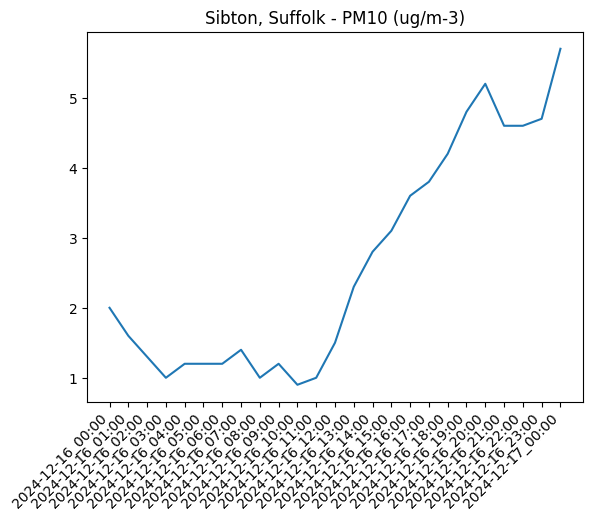

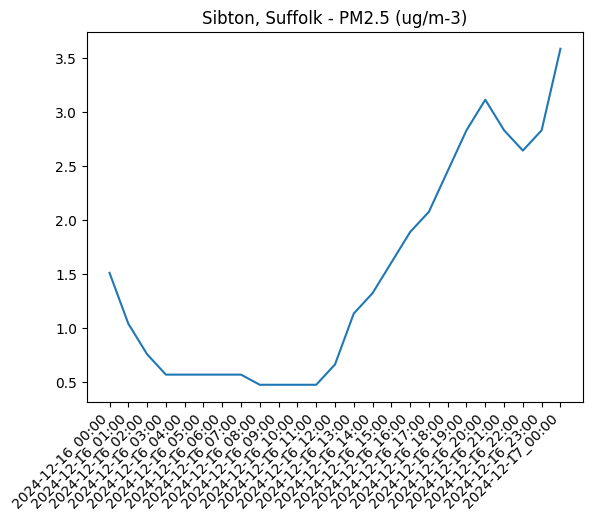

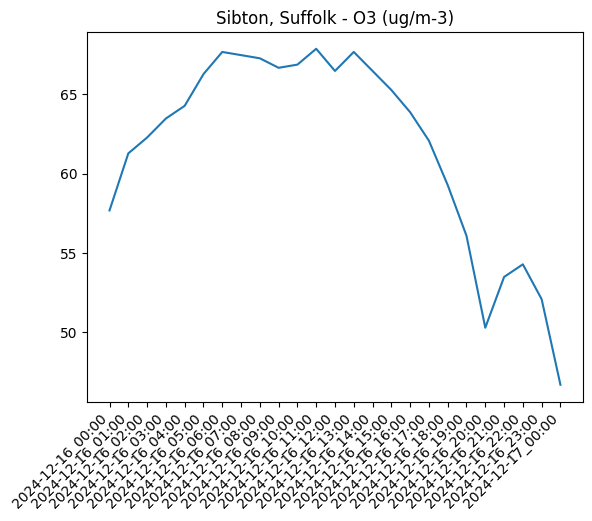

<Figure size 640x480 with 0 Axes>

In [ ]:
# Load data from the source/transformed bucket ('transformed' folder in this offline implementation)

import os
from matplotlib import pyplot as plt
%matplotlib inline

# Get all files in the transformed folder
transformed_files = os.listdir("transformed")
# Load all json files in the transformed folder
for transformed_file in transformed_files:
    if transformed_file.endswith(".json"):
        with open(f"transformed/{transformed_file}", "r") as f:
            transformed_data = json.load(f)
            # Create graph for each timeseries
            # Set the title of this timeseries
            for timeseries in transformed_data["data"]:
                x = []
                y = []
                for data in timeseries["data"]:
                    x.append(data["timestamp"])
                    y.append(data["value"])
                plt.title(f"{transformed_data['name']} - {timeseries['label']} ({timeseries['uom'].replace(".", "/")})")
                plt.plot(x, y, label=timeseries["label"])
                # Rotate the x axis labels so they don't overlap
                plt.xticks(rotation=45, ha='right')
                # Save the plot png to the 'out' folder (represents the public S3 bucket)
                plt.savefig(f"out/{transformed_data['name'].replace(', ', '_')}-{timeseries['label'].replace(' ', '_')}-{today}.png", bbox_inches="tight", dpi=80)
                # Show the plot in the notebook
                plt.show()
                # Clear the plot so we can make a new one in the next iteration
                plt.clf()
